Loading Koch's model dataset...
Koch's model dataset shape:  (200001, 100)


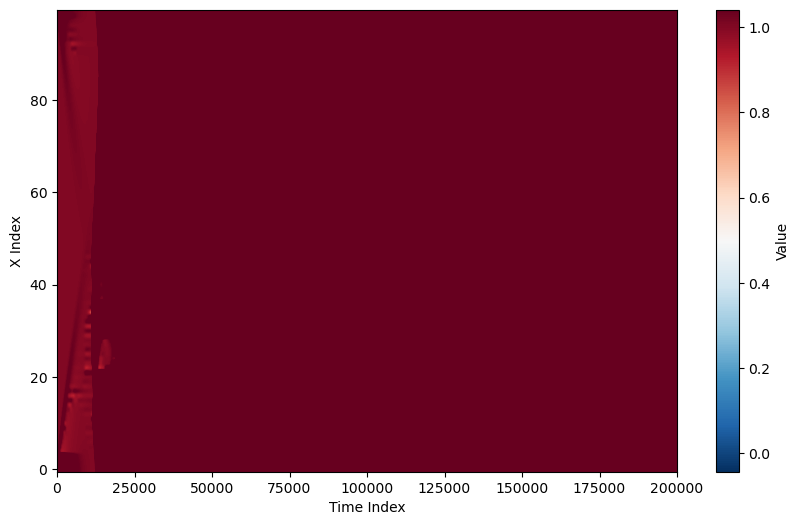

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sindy
import sindy_shred
from processdata import load_data
from processdata import TimeSeriesDataset
import pysindy as ps
from pysindy.differentiation import FiniteDifference


# load the Koch dataset
print("Loading Koch's model dataset...")
data = np.load('files_for_submission/Kochs_model_dataset.npy', allow_pickle=True)
print("Koch's model dataset shape: ", data.shape)

def plot_1d_dataset_as_heatmap(dataset1d, title = ""): 

    plt.figure(figsize=(10, 6))
    plt.imshow(dataset1d.T, aspect='auto', cmap='RdBu_r', origin='lower', vmin = -0.04288087, vmax = 1.0402466)
    plt.colorbar(label='Value')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    # plt.title(title, fontdict={'fontsize':20})
    plt.show()
    
def plot_1d_dataset_as_heatmap_original_temp_scale(dataset1d, title = ""): 

    plt.figure(figsize=(10, 6))
    plt.imshow(dataset1d.T, aspect='auto', cmap='jet', origin='lower')
    plt.colorbar(label='Value')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    # plt.title(title, fontdict={'fontsize':20})
    plt.show()   
    
plot_1d_dataset_as_heatmap(data, title = "Koch's model dataset - normalized scale")

Koch model dataset shape: T=200001, n=100
 Cropped Koch model dataset to shape: (140001, 100)
factor for time subsampling: 28
Applying wave straightening with shift_per_row=-0.188
 shape of load_X before straightening:  (5001, 100)


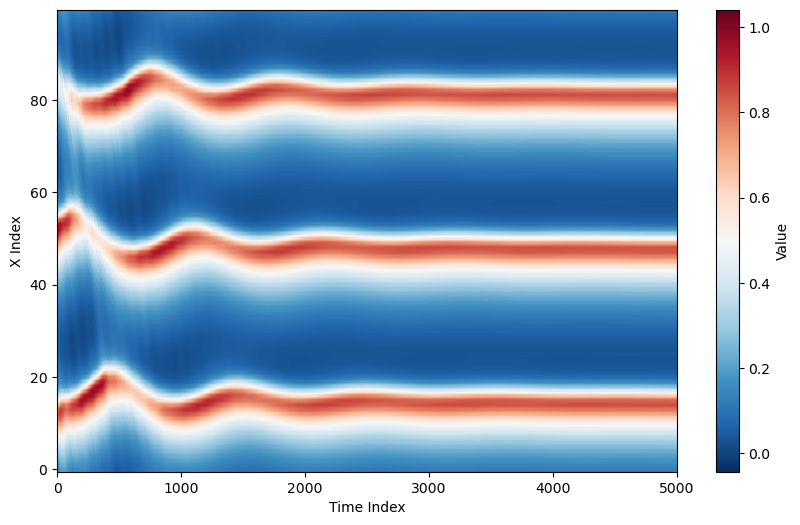

In [2]:
def straighten_data(data, shift_per_row):
    """
    Straighten x-direction rotation over time via row-wise circular *fractional* shifts.

    Args:
        data: array of shape (T, n)
        shift_per_row: scalar (pixels per timestep for every row)

    Returns:
        straightened: array of shape (T, n)
    """
    T, n = data.shape
    
    # FFT along the spatial dimension (axis 1)
    data_fft = np.fft.fft(data, axis=1)
    
    # Wavenumbers (frequencies)
    # fftfreq returns f = k/n corresponding to the frequencies
    freqs = np.fft.fftfreq(n)
    
    # Shifts for each row: shape (T, 1)
    # We assume the shift accumulates linearly with time index
    shifts = (np.arange(T) * shift_per_row).reshape(-1, 1)
    
    # Fourier shift theorem: f(x - d) <-> F(k) * exp(-2*pi*i * f * d)
    # We want to shift by 'shifts'.
    phase_shift = np.exp(-2j * np.pi * freqs[np.newaxis, :] * shifts)
    
    data_shifted_fft = data_fft * phase_shift
    
    data_shifted = np.fft.ifft(data_shifted_fft, axis=1)
    
    return np.real(data_shifted)

def preprocessing_Koch_model(dataset, T_final):
    
    T, n = dataset.shape
    print(f"Koch model dataset shape: T={T}, n={n}")
    if T > T_final:
        t_start_stable = 60_000
        dataset_cropped = dataset[t_start_stable:, :]
        
        print(f" Cropped Koch model dataset to shape: {dataset_cropped.shape}")
    else:
        dataset_cropped = dataset
        print(" No cropping needed for Koch model dataset.")
        
    T, n = dataset_cropped.shape
    if T > T_final:
        # we have to subsample in time
        factor = T // T_final
        print(f"factor for time subsampling: {factor}")
        dataset_cropped = dataset_cropped[::factor, :]
    
    # cancel out the rotation
    SHIFT_PER_ROW =  -0.188  # pixels per timestep - adjust as needed
    print(f"Applying wave straightening with shift_per_row={SHIFT_PER_ROW}")
    print(" shape of load_X before straightening: ", dataset_cropped.shape)
    Koch_model_straightened = straighten_data(
        dataset_cropped, shift_per_row=SHIFT_PER_ROW
    )

    Koch_model_straightened_minmax = (Koch_model_straightened - np.min(Koch_model_straightened)) / (np.max(Koch_model_straightened) - np.min(Koch_model_straightened))
    return Koch_model_straightened_minmax

T_final = 5_000  # desired number of time steps
data_koch_model_processed = preprocessing_Koch_model(data, T_final)
plot_1d_dataset_as_heatmap(data_koch_model_processed, title = "Koch's model dataset - processed")

In [3]:
n, m = data_koch_model_processed.shape
lags = 25
num_sensors = 20
print(" n, m = ", n, m)
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)


 n, m =  5001 100


In [4]:
last_train_index = int(0.8 * (n - lags))
train_indices = np.arange(0, last_train_index)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
n_valid_test = valid_test_indices.shape[0]
valid_indices = valid_test_indices[:n_valid_test//2]
test_indices = valid_test_indices[n_valid_test//2:]
n_train = train_indices.shape[0]
n_valid = valid_indices.shape[0]
n_test = test_indices.shape[0]
print(" n_train = ", n_train, " n_valid = ", n_valid, " n_test = ", n_test)

 n_train =  3980  n_valid =  498  n_test =  498


In [5]:
transformed_X = data_koch_model_processed
print(" shape of transformed_X:", transformed_X.shape   )

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
# device = torch.device("mps") if torch.backends.mps.is_available() else 'cpu'
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

print("Training data input shape:", train_data_in.shape, " on device:", train_data_in.device)
print("Validation data input shape:", valid_data_in.shape, " on device:", valid_data_in.device)
print("Test data input shape:", test_data_in.shape, " on device:", test_data_in.device)
   
### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

print("Training data output shape:", train_data_out.shape, " on device:", train_data_out.device)
print("Validation data output shape:", valid_data_out.shape, " on device:", valid_data_out.device)
print("Test data output shape:", test_data_out.shape, " on device:", test_data_out.device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

 shape of transformed_X: (5001, 100)
Using device: cpu
Training data input shape: torch.Size([3980, 25, 20])  on device: cpu
Validation data input shape: torch.Size([498, 25, 20])  on device: cpu
Test data input shape: torch.Size([498, 25, 20])  on device: cpu
Training data output shape: torch.Size([3980, 100])  on device: cpu
Validation data output shape: torch.Size([498, 100])  on device: cpu
Test data output shape: torch.Size([498, 100])  on device: cpu


In [6]:
dt = 0.1 #4.75924829840751e-08 # 0.05 
hidden_layers = 10
latent_dim = 3 # 2
dropout = 0.3
poly_order = 3 # use 3 !
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

l1 = 35
l2 = 60
lr = 2e-3
batch_size = 128
num_epochs = 100 #800
threshold = 0.005
sindy_regularization = 2 #10
mean_zero_regularization = 0.1
variance_regularization = 0.1

shred = sindy_shred.SINDy_SHRED(num_sensors, m, hidden_size=latent_dim, hidden_layers=hidden_layers, l1=l1, l2=l2, dropout=dropout,
                                 library_dim=library_dim, poly_order=poly_order,
                                include_sine=include_sine, dt=dt, device=device).to(device)

# Ensure model is on the correct device before training
shred = shred.to(device)


In [7]:

# # training the SINDy-SHRED model
# shred.train()
# validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=batch_size, num_epochs=num_epochs,
#                                     lr=lr, verbose=True, threshold=threshold, patience=5, sindy_regularization=sindy_regularization,
#                                     mean_zero_regularization = mean_zero_regularization, variance_regularization=variance_regularization,
#                                     optimizer="AdamW", thres_epoch=100)

# # Rate of sparsity
# # Make sure the rate of sparsity is over 0.2!!
# print(" sindy sparsity coefficient: ", torch.mean(shred.e_sindy.coefficient_mask*1.0))
# # on the SST dataset we are able to get this to 0.05 -- should achieve similar on RDE before forecasting!

# test_recons = shred(test_dataset.X).detach().cpu().numpy()
# test_ground_truth = test_dataset.Y.detach().cpu().numpy()
# print(" REL ERRN TEST DATA: ", np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))


In [8]:

# save model weights of the trained shred model:
torch.save(shred.state_dict(), "shred_weights/sindy_shred_rde_model_weights.pth"); print(" Model weights saved. ")

 Model weights saved. 


In [9]:
# load the model weights later via:
shred.load_state_dict(torch.load("shred_weights/sindy_shred_rde_model_weights.pth"))


<All keys matched successfully>

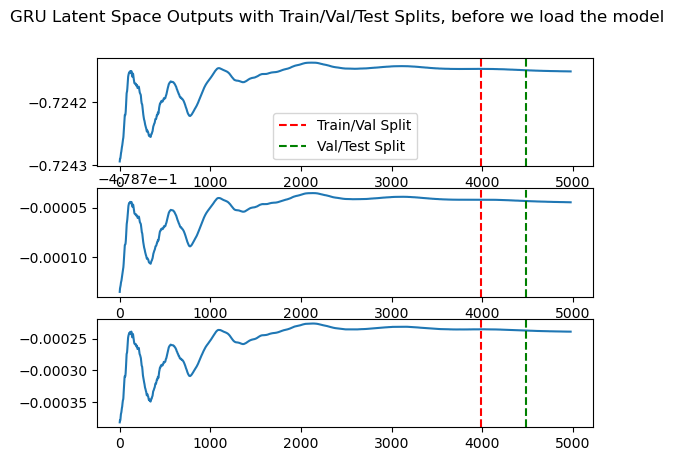

In [10]:

shred.eval()
# here we should plot the train, val and test GRU outputs to make sure there arent any discontinuities
all_dataset = torch.cat((train_dataset.X, valid_dataset.X, test_dataset.X), dim=0)

gru_outs, sindy_outs = shred.gru_outputs(all_dataset, sindy=True)
# differentiation_method = FiniteDifference()


fig, ax = plt.subplots(latent_dim)
# addd title: 
fig.suptitle('GRU Latent Space Outputs with Train/Val/Test Splits, before we load the model')
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())
    # add vertical lines to indicate train/val/test splits
    ax[i].axvline(x=n_train, color='r', linestyle='--', label='Train/Val Split')
    ax[i].axvline(x=n_train + n_valid, color='g', linestyle='--', label='Val/Test Split')
ax[0].legend()

 shape of gru_outs_numpy:  (4975, 5, 3)
 dt for differentiation:  0.001
 shape of gru_outs_deriv:  (4975, 5, 3)
 shape of gru_outs_double_deriv:  (4975, 5, 3)


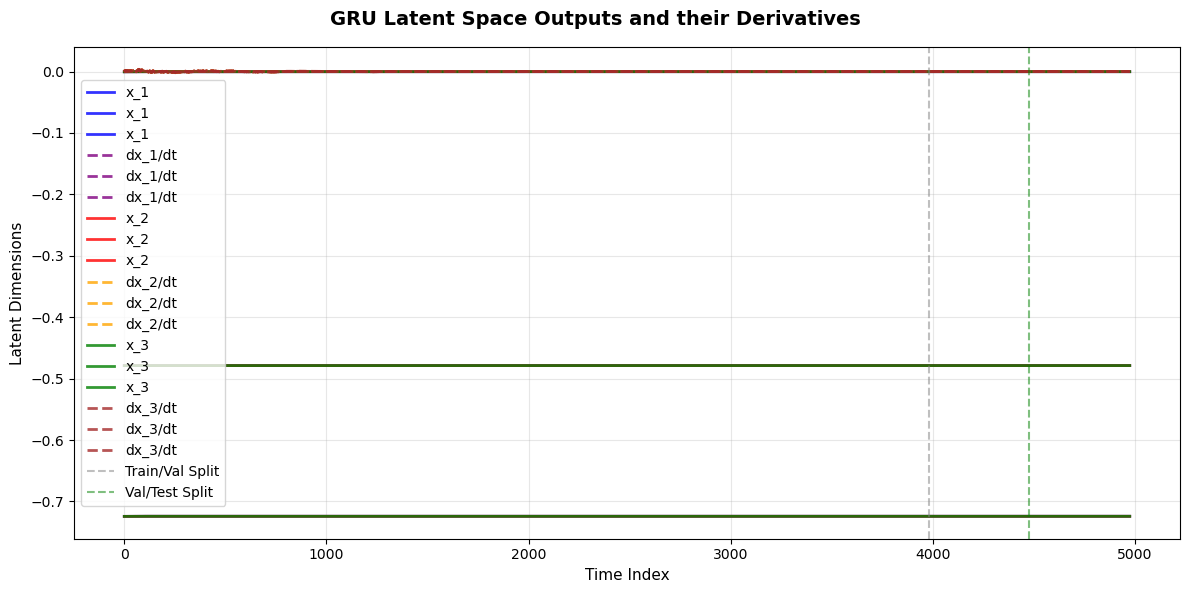

In [11]:
# compute the first derivative of the gru outputs using finite difference
gru_outs_numpy = gru_outs.detach().cpu().numpy()

print(" shape of gru_outs_numpy: ", gru_outs_numpy.shape)

# differentiation_method = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 10})
differentiation_method = ps.differentiation.FiniteDifference()
# compute x dot:
dt_for_differentiation = 0.001  # time step used during training 
print(" dt for differentiation: ", dt_for_differentiation)
gru_outs_deriv = differentiation_method._differentiate(gru_outs_numpy, dt_for_differentiation)
print(" shape of gru_outs_deriv: ", gru_outs_deriv.shape)
gru_outs_double_deriv = differentiation_method._differentiate(gru_outs_deriv, dt_for_differentiation)
print(" shape of gru_outs_double_deriv: ", gru_outs_double_deriv.shape)

# plot x and x dot on a single plot for all latent dimensions
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('GRU Latent Space Outputs and their Derivatives', fontsize=14, fontweight='bold')

colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i in range(latent_dim):
    # Plot x for each dimension
    ax.plot(gru_outs_numpy[:, i], linewidth=2, alpha=0.8, color=colors[i % len(colors)], label=f'x_{i+1}')
    # Plot dx/dt for each dimension
    ax.plot(gru_outs_deriv[:, i], linewidth=2, alpha=0.8, color=colors[(i + latent_dim) % len(colors)], linestyle='--', label=f'dx_{i+1}/dt')

ax.set_ylabel('Latent Dimensions', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvline(x=n_train, color='gray', linestyle='--', alpha=0.5, label='Train/Val Split')
ax.axvline(x=n_train + n_valid, color='green', linestyle='--', alpha=0.5, label='Val/Test Split')
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('Time Index', fontsize=11)

plt.tight_layout()
plt.show()

 GRU OUTS STATS BEFORE NORMALIZATION dim  0  min:  tensor(-0.7243, grad_fn=<MinBackward1>)  max:  tensor(-0.7241, grad_fn=<MaxBackward1>)
 GRU OUTS STATS BEFORE NORMALIZATION dim  1  min:  tensor(-0.4788, grad_fn=<MinBackward1>)  max:  tensor(-0.4787, grad_fn=<MaxBackward1>)
 GRU OUTS STATS BEFORE NORMALIZATION dim  2  min:  tensor(-0.0004, grad_fn=<MinBackward1>)  max:  tensor(-0.0002, grad_fn=<MaxBackward1>)
 using dt for differentiation:  0.001
 x shape:  (3979, 3)  x_deriv shape:  (3979, 3)
 shape of x_second_order_ODE:  (3979, 6)
(x0)' = 1.000 x3
(x1)' = 1.000 x4
(x2)' = 1.000 x5
(x3)' = -0.251 1 + -0.055 x0 + -0.060 x1 + -0.047 x2 + -3.055 x3 + -3.552 x4 + -2.753 x5 + -0.120 x0^2 + -0.119 x0 x1 + -0.119 x0 x2 + -1.139 x0 x3 + -1.139 x0 x4 + -1.058 x0 x5 + -0.118 x1^2 + -0.118 x1 x2 + -1.224 x1 x3 + -1.226 x1 x4 + -1.140 x1 x5 + -0.119 x2^2 + -1.062 x2 x3 + -1.059 x2 x4 + -0.984 x2 x5 + 1.835 x3^2 + 2.310 x3 x4 + -0.509 x3 x5 + -0.152 x4^2 + 1.426 x4 x5 + -3.768 x5^2 + -0.015 x0^3

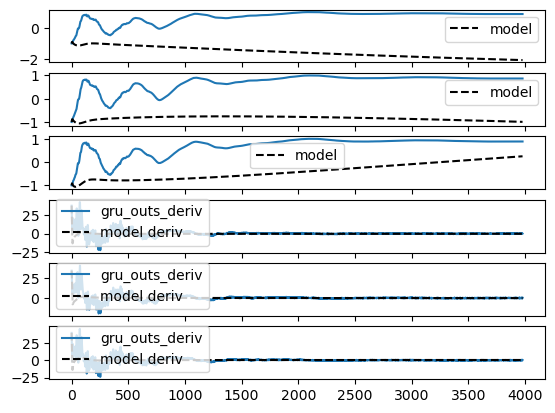

 GRU OUTS ALL STATS BEFORE NORMALIZATION dim  0  min:  -0.7242969870567322  max:  -0.7241368293762207
 GRU OUTS ALL STATS BEFORE NORMALIZATION dim  1  min:  -0.47883665561676025  max:  -0.4787353277206421
 GRU OUTS ALL STATS BEFORE NORMALIZATION dim  2  min:  -0.0003844140737783164  max:  -0.0002263730566482991
rel error on training data:  1.0144886
rel error on val model:  1.0123882
rel error on test data:  1.0118576


In [13]:
# from pysindy.optimizers import MIOSR

gru_outs, sindy_outs = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs = gru_outs[:,0,:]

poly_order = 3
threshold = 0.2
alpha_for_sindy = 2
dt_for_sindy = dt_for_differentiation

###############Normalization###############

for i in range(latent_dim):
    print(" GRU OUTS STATS BEFORE NORMALIZATION dim ", i, " min: ", torch.min(gru_outs[:,i]), " max: ", torch.max(gru_outs[:,i]))
    gru_outs[:,i] = (gru_outs[:,i] - torch.min(gru_outs[:,i])) / (torch.max(gru_outs[:,i])-torch.min(gru_outs[:,i]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()

# differentiation_method = ps.differentiation.SmoothedFiniteDifference()
# compute x dot:

print(" using dt for differentiation: ", dt_for_sindy)
x_deriv = differentiation_method._differentiate(x, dt_for_sindy)
print(" x shape: ", x.shape,
      " x_deriv shape: ", x_deriv.shape)

x_second_order_ODE = np.concatenate((x, x_deriv), axis=1)
print(" shape of x_second_order_ODE: ", x_second_order_ODE.shape)

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 9})

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, alpha=alpha_for_sindy),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)

# model = ps.SINDy(
#     optimizer=MIOSR(group_sparsity=(2,2,2,4,5,5), alpha=5000),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
# )


t_points = np.arange(0, len(x)) * (dt_for_sindy)

# model.fit(x, t=t_points)
# model.print()

model.fit(x_second_order_ODE, t=t_points)
model.print()


###############Plot the discovered SINDy model###############

t_train = np.arange(0, len(gru_outs)) * dt_for_sindy
# init_cond = np.zeros(latent_dim)
# init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
# x_sim = model.simulate(init_cond, t_train)

init_cond = np.zeros(2*latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(2*latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")
    ax[i].legend()
    
# plot also the derivatives
for i in range(latent_dim):
    ax[i + latent_dim].plot((differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[:,i], label="gru_outs_deriv")
    ax[i + latent_dim].plot(x_sim[:,i + latent_dim], "k--", label="model deriv")
    ax[i + latent_dim].legend()
plt.show()  

gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

gru_outs_all = np.zeros((n_train + n_valid + n_test - 3, latent_dim))
gru_outs_all[:n_train-1,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[n_train-1:n_train+n_valid-2,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[n_train+n_valid-2:,:] = gru_outs_test.detach().cpu().numpy()

gru_outs_numpy = gru_outs_train.detach().cpu().numpy()

for i in range(latent_dim):
    print(" GRU OUTS ALL STATS BEFORE NORMALIZATION dim ", i, " min: ", np.min(gru_outs_all[:,i]), " max: ", np.max(gru_outs_all[:,i]))
    gru_outs_all[:,i] = (gru_outs_all[:,i] - np.min(gru_outs_numpy[:,i])) / (np.max(gru_outs_numpy[:,i])-np.min(gru_outs_numpy[:,i]))

gru_outs_all = 2 * gru_outs_all - 1

def error_on_val(shred, dataset_to_compare, dt_for_sindy):
    
    shred.eval()
    n_to_compare = len(dataset_to_compare)
    
    gru_outs_compare, _ = shred.gru_outputs(dataset_to_compare.X, sindy=True)
    gru_outs_compare = gru_outs_compare[:,0,:]
    gru_outs_compare_np = gru_outs_compare.detach().cpu().numpy()
    
    # Normalize the GRU outputs to [-1, 1] range, same as in model discovery
    # Use the training data min/max for consistent normalization
    for i in range(latent_dim):
        gru_outs_compare_np[:, i] = (gru_outs_compare_np[:, i] - np.min(gru_outs_numpy[:, i])) / (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i]))
    
    gru_outs_compare_np = 2 * gru_outs_compare_np - 1
    
    t_to_compare = np.arange(0, n_to_compare-1) * (  dt_for_sindy)
    # init_cond = np.zeros(latent_dim)
    # init_cond[:latent_dim] = gru_outs_compare_np[0, :]
    init_cond = np.zeros(2*latent_dim)
    init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
    init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]

    x_sim_compare = model.simulate(init_cond, t_to_compare)
    
    # now we need to get the reconstruction from shred:
    test_recons = shred(dataset_to_compare.X).detach().cpu().numpy()

    ground_truth = dataset_to_compare.Y.detach().cpu().numpy()
    error = np.linalg.norm(test_recons - ground_truth) / np.linalg.norm(ground_truth)
    return error

print("rel error on training data: ", error_on_val(shred, train_dataset, dt_for_sindy))
print("rel error on val model: ", error_on_val(shred, valid_dataset, dt_for_sindy))
print("rel error on test data: ", error_on_val(shred, test_dataset, dt_for_sindy))

 GRU OUTS TEST STATS BEFORE NORMALIZATION dim  0  min:  -0.7241509  max:  -0.724149
 GRU OUTS TEST STATS BEFORE NORMALIZATION dim  1  min:  -0.47874466  max:  -0.4787433
 GRU OUTS TEST STATS BEFORE NORMALIZATION dim  2  min:  -0.000239207  max:  -0.00023741051
 x_sim_test shape:  (497, 6)
 gru_outs_test_np shape:  (497, 3)


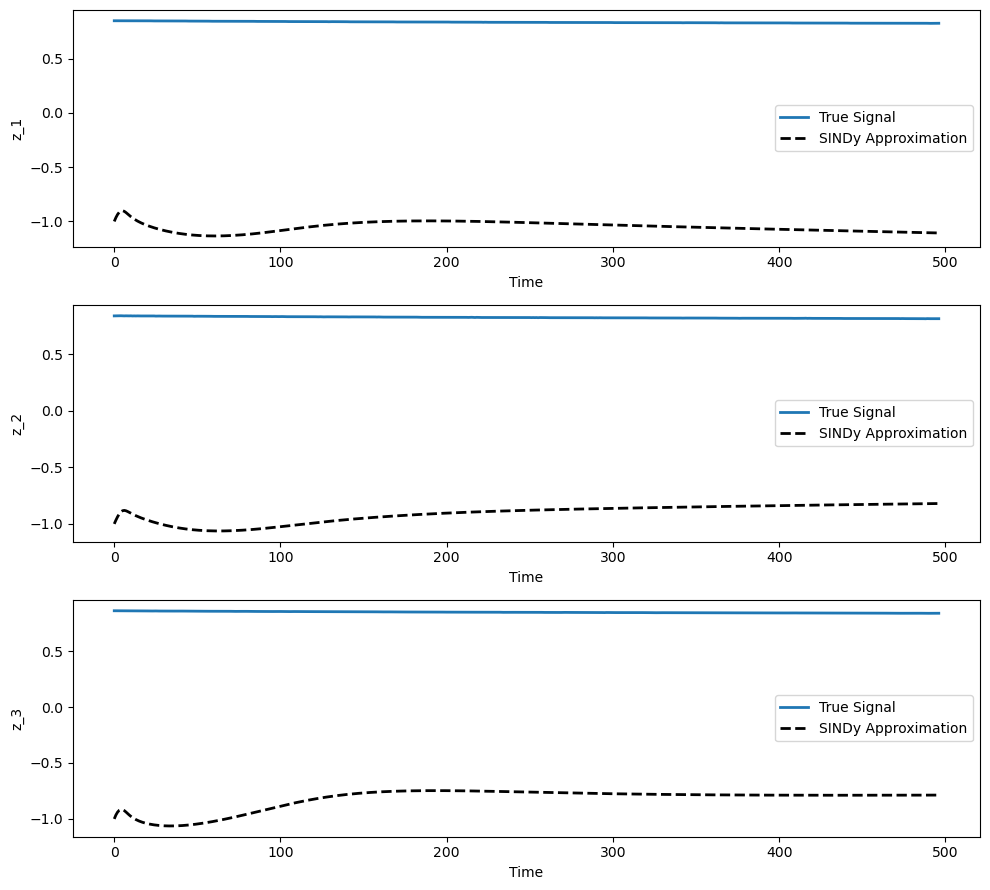

In [14]:
###############Normalization###############
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

for i in range(latent_dim):
    print(" GRU OUTS TEST STATS BEFORE NORMALIZATION dim ", i, " min: ", np.min(gru_outs_test_np[:,i]), " max: ", np.max(gru_outs_test_np[:,i]))
    gru_outs_test_np[:, i] = (gru_outs_test_np[:, i] - np.min(gru_outs_numpy[:, i])) / (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i]))

gru_outs_test_np = 2 * gru_outs_test_np - 1  # Transform to [-1, 1]

################Forward simulation with the model################
t_test = np.arange(0, n_test-1) * (  dt_for_sindy)

# init_cond = np.zeros(latent_dim)
# init_cond[:latent_dim] = gru_outs_test_np[0, :]
init_cond = np.zeros(2*latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]


x_sim_test = model.simulate(init_cond, t_test)

# Plotting for each latent dimension: True vs SINDy
fig, ax = plt.subplots(latent_dim, figsize=(10, latent_dim * 3))

print(" x_sim_test shape: ", x_sim_test.shape)
print(" gru_outs_test_np shape: ", gru_outs_test_np.shape)

for i in range(latent_dim):
    ax[i].plot(gru_outs_test_np[:, i], label='True Signal', linewidth=2)
    ax[i].plot(x_sim_test[:, i], "k--", label='SINDy Approximation', linewidth=2)
    ax[i].legend()
    ax[i].set_ylabel(f'z_{i+1}')
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

###############Predict back in the pixel space###############

# Step 1: Revert the normalization to original scale
gru_outs_test_np = (gru_outs_test_np + 1) / 2  # Revert from [-1, 1] to [0, 1]

# for i in range(latent_dim):  # Assuming 3 latent dimensions for this example
#     gru_outs_test_np[:, i] = gru_outs_test_np[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Step 2: Decoder reconstruction using the decoder model
latent_pred = torch.FloatTensor(gru_outs_test_np).to(device)

# Pass through the decoder
output = shred.linear1(latent_pred)
# output = shred.dropout(output) # TODO:you shouldnt do dropout at inference!
output = torch.nn.functional.tanh(output)
output = shred.linear2(output)
# output = shred.dropout(output)  # TODO:you shouldnt do dropout at inference!
output = torch.nn.functional.tanh(output)
output = shred.linear3(output)

output_np = output.detach().cpu().numpy()

Please provide the following variables to call the function:
- sst_locs: indices of sensor locations
- x: x-coordinates of spatial points
- y: y-coordinates of spatial points

Then call: plot_rescaled_latent_reconstructions(shred, gru_outs_numpy, sst_locs, x, y)
 latent_vectors_tensor shape:  torch.Size([3, 3])
Output reconstructed shape: (3, 100)


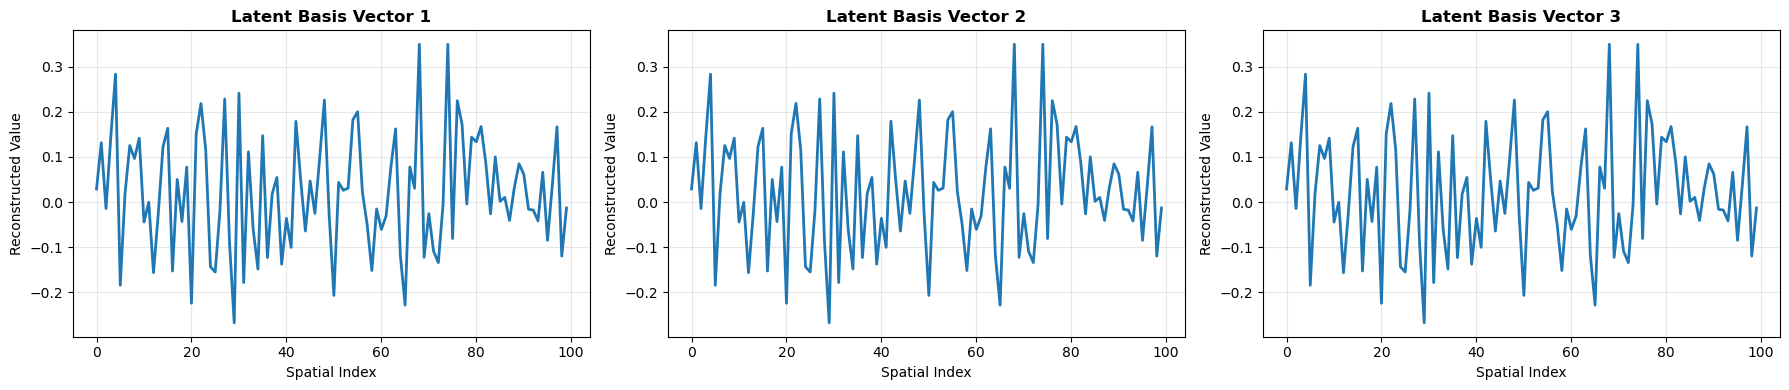

In [21]:
import traceback

def plot_rescaled_latent_reconstructions(decoder_model, gru_outs_numpy, sst_locs, x_coords, y_coords):
    """
    Rescales and plots the decoder reconstruction for specific latent space vectors.
    
    Args:
        decoder_model (nn.Module): The decoder model for reconstruction.
        gru_outs_numpy (np.array): Original latent space data for Min-Max scaling reversal.
        sst_locs (np.array): Indices of sensor locations in the spatial grid.
        x_coords (np.array): X coordinates of all spatial points.
        y_coords (np.array): Y coordinates of all spatial points.
    """
    # Define the specific latent space vectors (identity matrix for each basis)
    latent_vectors = np.eye(latent_dim)
    latent_vectors_tensor = torch.FloatTensor(latent_vectors).to(device)

    # Rescale latent vectors to match the original data range
    for i in range(latent_dim):
        latent_vectors_tensor[:, i] = latent_vectors_tensor[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform reconstruction using the decoder
    output_reconstructed = decoder_model.linear1(latent_vectors_tensor)
    output_reconstructed = torch.nn.functional.tanh(output_reconstructed)
    output_reconstructed = decoder_model.linear2(output_reconstructed)
    output_reconstructed = torch.nn.functional.tanh(output_reconstructed)
    output_reconstructed = decoder_model.linear3(output_reconstructed)

    # Convert reconstructed data back to numpy
    output_reconstructed_np = output_reconstructed.detach().cpu().numpy()
    
    print(f"Output reconstructed shape: {output_reconstructed_np.shape}")
    print(f"Number of sensors (sst_locs): {len(sst_locs)}")
    print(f"X coordinates shape: {x_coords.shape}")
    print(f"Y coordinates shape: {y_coords.shape}")

    # Plot each reconstructed result
    for i in range(latent_dim):
        try:
            # Create scatter plot for sparse data
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Extract values at sensor locations
            values_at_sensors = output_reconstructed_np[i, :len(sst_locs)]
            x_at_sensors = x_coords[sst_locs]
            y_at_sensors = y_coords[sst_locs]
            
            # Create scatter plot
            scatter = ax.scatter(x_at_sensors, y_at_sensors, c=values_at_sensors, 
                                cmap='jet', s=50, edgecolors='black', linewidth=0.5)
            
            ax.set_title(f'Latent Basis Vector {i+1} Reconstruction', fontsize=14, fontweight='bold')
            ax.set_xlabel('x', fontsize=12)
            ax.set_ylabel('y', fontsize=12)
            ax.set_aspect('equal')
            plt.colorbar(scatter, ax=ax, label='Value')
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error plotting basis vector {i+1}: {e}")
            traceback.print_exc()

# You need to provide the sensor locations and coordinates
# These should come from your data loading section
# Example call (you'll need to replace these with your actual variables):
# plot_rescaled_latent_reconstructions(shred, gru_outs_numpy, sst_locs, x, y)

print("Please provide the following variables to call the function:")
print("- sst_locs: indices of sensor locations")
print("- x: x-coordinates of spatial points")  
print("- y: y-coordinates of spatial points")
print("\nThen call: plot_rescaled_latent_reconstructions(shred, gru_outs_numpy, sst_locs, x, y)")

# Create a single figure with latent_dim subplots side by side
fig, axes = plt.subplots(1, latent_dim, figsize=(6*latent_dim, 4))

# If latent_dim is 1, axes won't be an array, so wrap it
if latent_dim == 1:
    axes = [axes]

# Define the specific latent space vectors (identity matrix for each basis)
latent_vectors = np.eye(latent_dim)
latent_vectors_tensor = torch.FloatTensor(latent_vectors).to(device)
print(" latent_vectors_tensor shape: ", latent_vectors_tensor.shape)

# Rescale latent vectors to match the original data range
for i in range(latent_dim):
    latent_vectors_tensor[:, i] = latent_vectors_tensor[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Perform reconstruction using the decoder
shred.eval()
output_reconstructed = shred.linear1(latent_vectors_tensor)
output_reconstructed = torch.nn.functional.tanh(output_reconstructed)
output_reconstructed = shred.linear2(output_reconstructed)
output_reconstructed = torch.nn.functional.tanh(output_reconstructed)
output_reconstructed = shred.linear3(output_reconstructed)

# Convert reconstructed data back to numpy
output_reconstructed_np = output_reconstructed.detach().cpu().numpy()

print(f"Output reconstructed shape: {output_reconstructed_np.shape}")

# Plot each reconstructed result as a line plot
for i in range(latent_dim):
    axes[i].plot(np.arange(m), output_reconstructed_np[i, :], linewidth=2)
    axes[i].set_title(f'Latent Basis Vector {i+1}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Spatial Index', fontsize=10)
    axes[i].set_ylabel('Reconstructed Value', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
